# Segmentation in 2D using U-Nets with Delira - A very short introduction

*Author: Justus Schock, Alexander Moriz* 

*Date: 17.12.2018*
 
This Example shows how use the U-Net implementation in Delira with PyTorch.

Let's first setup the essential hyperparameters. We will use `delira`'s `HyperParameters`-class for this:

In [1]:
import torch
from delira.training import Hyperparameters

hyper_params = Hyperparameters(batch_size=16, # batchsize to use
                               num_epochs=10, # number of epochs to train
                               optimizer_cls=torch.optim.Adam, # optimization algorithm to use
                               optimizer_params={'lr': 1e-3}, # initialization parameters for this algorithm
                               criterions=[torch.nn.CrossEntropyLoss()], # the loss function
                               lr_sched_cls=None,  # the learning rate scheduling algorithm to use
                               lr_sched_params={}, # the corresponding initialization parameters
                               metrics=[]) # and some evaluation metrics

/home/temp/schock/conda/envs/delira/lib/python3.7/site-packages/pandas/core/tools/datetimes.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-01-07_11-20-03_12286/logs.
Waiting for redis server at 127.0.0.1:39791 to respond...
Waiting for redis server at 127.0.0.1:33926 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.

View the web UI at http://localhost:8888/notebooks/ray_ui.ipynb?token=0080887362abb737b94df5411b5617b3fe1187cdaca32393



Using torch multi processing


Couldn't import TensorFlow - disabling TensorBoard logging.


Since we did not specify any metric, only the `CrossEntropyLoss` will be calculated for each batch. Since we have a classification task, this should be sufficient. We will train our network with a batchsize of 64 by using `Adam` as optimizer of choice.

## Logging and Visualization
To get a visualization of our results, we should monitor them somehow. For logging we will use `Visdom`. To start a visdom server you need to execute the following command inside an environment which has visdom installed: 
```shell
visdom -port=9999
```
This will start a visdom server on port 9999 of your machine and now we can start to configure our logging environment. To view your results you can open [http://localhost:9999](http://localhost:9999) in your browser.

In [2]:
from trixi.logger import PytorchVisdomLogger
from delira.logging import TrixiHandler
import logging

logger_kwargs = {
    'name': 'ClassificationExampleLogger', # name of our logging environment
    'port': 9999 # port on which our visdom server is alive
}

logger_cls = PytorchVisdomLogger

# configure logging module (and root logger)
logging.basicConfig(level=logging.INFO,
                    handlers=[TrixiHandler(logger_cls, **logger_kwargs)])


# derive logger from root logger
# (don't do `logger = logging.Logger("...")` since this will create a new
# logger which is unrelated to the root logger
logger = logging.getLogger("Test Logger")


Visdom successfully connected to server
Process Process-1:
Traceback (most recent call last):
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/site-packages/trixi/logger/visdom/numpyvisdomlogger.py", line 85, in __show
    vis_task = queue.get()
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/temp/schock/conda/envs/delira/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/temp/schock/conda/envs/delira/lib/

Since a single visdom server can run multiple environments, we need to specify a (unique) name for our environment and need to tell the logger, on which port it can find the visdom server.

## Data Praparation
### Loading
Next we will create a small train and validation set (in this case they will be the same to show the overfitting capability of the UNet).

Our data is a brain MR-image thankfully provided by the [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki) in their [introduction](http://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox3/IntroBox3.html).

We first download the data and extract the T1 image and the corresponding segmentation:

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen("http://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox3/ExBox3.zip")
zipfile = ZipFile(BytesIO(resp.read()))
#zipfile_list = zipfile.namelist()
#print(zipfile_list)
img_file = zipfile.extract("ExBox3/T1_brain.nii.gz")
mask_file = zipfile.extract("ExBox3/T1_brain_seg.nii.gz")

Now, we load the image and the mask (they are both 3D), convert them to a 32-bit floating point numpy array and ensure, they have the same shape (i.e. that for each voxel in the image, there is a voxel in the mask):

In [4]:
import SimpleITK as sitk
import numpy as np

# load image and mask
img = sitk.GetArrayFromImage(sitk.ReadImage(img_file))
img = img.astype(np.float32)
mask = mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_file))
mask = mask.astype(np.float32)

assert mask.shape == img.shape
print(img.shape)

(192, 192, 174)


By querying the unique values in the mask, we get the following:

In [5]:
np.unique(mask)

array([0., 1., 2., 3.], dtype=float32)

This means, there are 4 classes (background and 3 types of tissue) in our sample.

Since we want to do a 2D segmentation, we extract a single slice out of the image and the mask (we choose slice 100 here) and plot it:

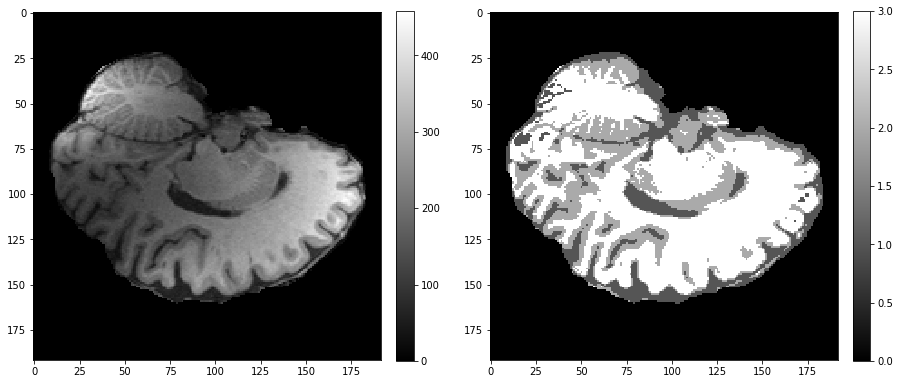

In [6]:
import matplotlib.pyplot as plt

# load single slice
img_slice = img[:, :, 100]
mask_slice = mask[:, :, 100]

# plot slices
plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.imshow(img_slice, cmap="gray")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(mask_slice, cmap="gray")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


To load the data, we have to use a `Dataset`. The following defines a very simple dataset, accepting an image slice, a mask slice and the number of samples. It always returns the same sample until `num_samples` samples have been returned.

In [7]:
from delira.data_loading import AbstractDataset

class CustomDataset(AbstractDataset):
    def __init__(self, img, mask, num_samples=1000):
        super().__init__(None, None, None, None)
        self.data = {"data": img.reshape(1, *img.shape), "label": mask.reshape(1, *mask.shape)}
        self.num_samples = num_samples
        
    def __getitem__(self, index):
        return self.data
    
    def __len__(self):
        return self.num_samples

Now, we can finally instantiate our datasets:

In [8]:
dataset_train = CustomDataset(img_slice, mask_slice, num_samples=10000)
dataset_val = CustomDataset(img_slice, mask_slice, num_samples=1)

### Augmentation
For Data-Augmentation we will apply a few transformations:

In [9]:
from batchgenerators.transforms import RandomCropTransform, \
                                        ContrastAugmentationTransform, Compose
from batchgenerators.transforms.spatial_transforms import ResizeTransform
from batchgenerators.transforms.sample_normalization_transforms import MeanStdNormalizationTransform

transforms = Compose([
    RandomCropTransform((150, 150), label_key="label"), # Perform Random Crops of Size 150 x 150 pixels
    ResizeTransform((224, 224), label_key="label"), # Resample these crops back to 224 x 224 pixels
    ContrastAugmentationTransform(), # randomly adjust contrast
    MeanStdNormalizationTransform(mean=[img_slice.mean()], std=[img_slice.std()])]) # use concrete values since we only have one sample (have to estimate it over whole dataset otherwise)

With these transformations we can now wrap our datasets into datamanagers:

In [10]:
from delira.data_loading import BaseDataManager, SequentialSampler, RandomSampler

manager_train = BaseDataManager(dataset_train, hyper_params.batch_size,
                                transforms=transforms,
                                sampler_cls=RandomSampler,
                                n_process_augmentation=4)

manager_val = BaseDataManager(dataset_val, hyper_params.batch_size,
                              transforms=transforms,
                              sampler_cls=SequentialSampler,
                              n_process_augmentation=4)

No DataLoader Class specified. Using BaseDataLoader
No DataLoader Class specified. Using BaseDataLoader


## Training

After we have done that, we can finally specify our experiment and run it. We will therfore use the already implemented `UNet2dPytorch`:

In [11]:
import warnings
warnings.simplefilter("ignore", UserWarning) # ignore UserWarnings raised by dependency code
warnings.simplefilter("ignore", FutureWarning) # ignore FutureWarnings raised by dependency code


from delira.training import PyTorchExperiment
from delira.training.train_utils import create_optims_default_pytorch
from delira.models.segmentation import UNet2dPyTorch

logger.info("Init Experiment")
experiment = PyTorchExperiment(hyper_params, UNet2dPyTorch,
                               name="Segmentation2dExample",
                               save_path="./tmp/delira_Experiments",
                               model_kwargs={'in_channels': 1, 'num_classes': 5},
                               optim_builder=create_optims_default_pytorch,
                               gpu_ids=[0])
experiment.save()

model = experiment.run(manager_train, manager_val)

Init Experiment
{'text': {'text': 'Hyperparameters:\n\tbatch_size = 16\n\tnum_epochs = 10\n\toptimizer_cls = <class \'torch.optim.adam.Adam\'>\n\toptimizer_params = {\n    "lr": 0.001\n}\n\t_criterions = [CrossEntropyLoss()]\n\tlr_sched_cls = None\n\tlr_sched_params = {}\n\t_metrics = []\n\n\tmodel_class = type'}}


{'value': {'value': 1.6397160291671753, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.5656602382659912, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.4839859008789062, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.2686834335327148, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 31.233861923217773, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          ...,
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.156069040298462, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          ...,
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7

{'value': {'value': 1.2714923620224, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          ...,
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.747

{'value': {'value': 1.29436457157135, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          ...,
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257],
          [-0.5257, -0.5257, -0.5257,  ..., -0.5257, -0.5257, -0.5257]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.74

{'value': {'value': 1.2942386865615845, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.2872077226638794, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.2726936340332031, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.2532469034194946, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.2095872163772583, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.1760271787643433, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.1366318464279175, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.1039793491363525, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 1.0847909450531006, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          ...,
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 1.0598058700561523, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          ...,
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 1.0422651767730713, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          ...,
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 1.0297373533248901, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          ...,
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927],
          [-0.6927, -0.6927, -0.6927,  ..., -0.6927, -0.6927, -0.6927]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 1.010299801826477, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7

{'value': {'value': 0.981177806854248, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7

{'value': {'value': 0.9514603614807129, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.

{'value': {'value': 0.9221206307411194, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.

{'value': {'value': 0.9123866558074951, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          ...,
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.8756775856018066, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          ...,
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.8342228531837463, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          ...,
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.7898730039596558, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          ...,
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703],
          [-0.4703, -0.4703, -0.4703,  ..., -0.4703, -0.4703, -0.4703]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.7221115827560425, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          ...,
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342]]],


        [[[-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          ...,
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.

{'value': {'value': 0.7760233879089355, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          ...,
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342]]],


        [[[-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          ...,
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.

{'value': {'value': 0.648040771484375, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          ...,
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342]]],


        [[[-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          ...,
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5

{'value': {'value': 0.6293879151344299, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          ...,
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342],
          [-0.7342, -0.7342, -0.7342,  ..., -0.7342, -0.7342, -0.7342]]],


        [[[-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          ...,
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.5384, -0.5384],
          [-0.5384, -0.5384, -0.5384,  ..., -0.5384, -0.

{'value': {'value': 0.5735967755317688, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          ...,
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.5718029737472534, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          ...,
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.5671509504318237, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          ...,
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.54732745885849, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          ...,
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733],
          [-0.4733, -0.4733, -0.4733,  ..., -0.4733, -0.4733, -0.4733]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.74

{'value': {'value': 0.5597758293151855, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          ...,
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.

{'value': {'value': 0.545038640499115, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          ...,
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5

{'value': {'value': 0.5436343550682068, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          ...,
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.

{'value': {'value': 0.5271235108375549, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          ...,
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.5942, -0.5942],
          [-0.5942, -0.5942, -0.5942,  ..., -0.5942, -0.

{'value': {'value': 0.47412949800491333, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5703, -0.5775, -0.4055,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.0754,  0.8350,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5094,  0.6546,  1.5400,  ..., -0.5775, -0.5775, -0.5775],
          ...,
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775]]],


        [[[-0.5589, -0.5661, -0.3961,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.0700,  0.8294,  ..., -0.5661, -0.5661, -0.5661],
          [-0.4988,  0.6512,  1.5259,  ..., -0.5661, -0.5661, -0.5661],
          ...,
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0

{'value': {'value': 0.4679740071296692, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5703, -0.5775, -0.4055,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.0754,  0.8350,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5094,  0.6546,  1.5400,  ..., -0.5775, -0.5775, -0.5775],
          ...,
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775]]],


        [[[-0.5589, -0.5661, -0.3961,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.0700,  0.8294,  ..., -0.5661, -0.5661, -0.5661],
          [-0.4988,  0.6512,  1.5259,  ..., -0.5661, -0.5661, -0.5661],
          ...,
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.

{'value': {'value': 0.4547763764858246, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5703, -0.5775, -0.4055,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.0754,  0.8350,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5094,  0.6546,  1.5400,  ..., -0.5775, -0.5775, -0.5775],
          ...,
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775]]],


        [[[-0.5589, -0.5661, -0.3961,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.0700,  0.8294,  ..., -0.5661, -0.5661, -0.5661],
          [-0.4988,  0.6512,  1.5259,  ..., -0.5661, -0.5661, -0.5661],
          ...,
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.

{'value': {'value': 0.4794318974018097, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5703, -0.5775, -0.4055,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.0754,  0.8350,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5094,  0.6546,  1.5400,  ..., -0.5775, -0.5775, -0.5775],
          ...,
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775],
          [-0.5775, -0.5775, -0.5775,  ..., -0.5775, -0.5775, -0.5775]]],


        [[[-0.5589, -0.5661, -0.3961,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.0700,  0.8294,  ..., -0.5661, -0.5661, -0.5661],
          [-0.4988,  0.6512,  1.5259,  ..., -0.5661, -0.5661, -0.5661],
          ...,
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.5661, -0.5661],
          [-0.5661, -0.5661, -0.5661,  ..., -0.5661, -0.

{'value': {'value': 0.5241397023200989, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          ...,
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620]]],


        [[[-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          ...,
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.

{'value': {'value': 0.5219535231590271, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          ...,
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620]]],


        [[[-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          ...,
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.

{'value': {'value': 0.5144880414009094, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          ...,
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620]]],


        [[[-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          ...,
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.

{'value': {'value': 0.5043419003486633, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          ...,
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620],
          [-0.5620, -0.5620, -0.5620,  ..., -0.5620, -0.5620, -0.5620]]],


        [[[-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          ...,
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.5058, -0.5058],
          [-0.5058, -0.5058, -0.5058,  ..., -0.5058, -0.

{'value': {'value': 0.4910679757595062, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          ...,
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645]]],


        [[[-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          ...,
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.

{'value': {'value': 0.4870090186595917, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          ...,
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645]]],


        [[[-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          ...,
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.

{'value': {'value': 0.46910297870635986, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          ...,
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645]]],


        [[[-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          ...,
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0

{'value': {'value': 0.4706672430038452, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          ...,
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6645, -0.6645, -0.6645]]],


        [[[-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          ...,
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.7324, -0.7324],
          [-0.7324, -0.7324, -0.7324,  ..., -0.7324, -0.

{'value': {'value': 0.445682168006897, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          ...,
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203]]],


        [[[-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          ...,
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6

{'value': {'value': 0.44557079672813416, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          ...,
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203]]],


        [[[-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          ...,
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0

{'value': {'value': 0.4360976219177246, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          ...,
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203]]],


        [[[-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          ...,
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.

{'value': {'value': 0.4303329586982727, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          ...,
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203],
          [-0.7203, -0.7203, -0.7203,  ..., -0.7203, -0.7203, -0.7203]]],


        [[[-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          ...,
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.6832, -0.6832],
          [-0.6832, -0.6832, -0.6832,  ..., -0.6832, -0.

{'value': {'value': 0.44563454389572144, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.4444344639778137, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.43788352608680725, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.42560064792633057, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.42013102769851685, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          ...,
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.42200449109077454, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          ...,
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.6739649176597595, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          ...,
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4476059079170227, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          ...,
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248],
          [-0.5248, -0.5248, -0.5248,  ..., -0.5248, -0.5248, -0.5248]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.464981347322464, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          ...,
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5

{'value': {'value': 0.4436270296573639, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          ...,
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.

{'value': {'value': 0.45737549662590027, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          ...,
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0

{'value': {'value': 0.443354070186615, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          ...,
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5607, -0.5607],
          [-0.5607, -0.5607, -0.5607,  ..., -0.5607, -0.5

{'value': {'value': 0.40064188838005066, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          ...,
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.39062243700027466, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          ...,
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.3857775628566742, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          ...,
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3786260783672333, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          ...,
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029],
          [-0.6029, -0.6029, -0.6029,  ..., -0.6029, -0.6029, -0.6029]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4306831359863281, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          ...,
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4264281988143921, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          ...,
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4153038263320923, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          ...,
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.41309577226638794, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          ...,
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245],
          [-0.7245, -0.7245, -0.7245,  ..., -0.7245, -0.7245, -0.7245]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.40086057782173157, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          ...,
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907]]],


        [[[-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          ...,
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0

{'value': {'value': 0.40118029713630676, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          ...,
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907]]],


        [[[-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          ...,
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0

{'value': {'value': 0.8050934672355652, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          ...,
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907]]],


        [[[-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          ...,
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.

{'value': {'value': 0.5290675163269043, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          ...,
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907],
          [-0.5907, -0.5907, -0.5907,  ..., -0.5907, -0.5907, -0.5907]]],


        [[[-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          ...,
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.5091, -0.5091],
          [-0.5091, -0.5091, -0.5091,  ..., -0.5091, -0.

{'value': {'value': 0.5795840620994568, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6620,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6620, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          ...,
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.5166268348693848, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6620,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6620, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          ...,
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3881257176399231, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6620,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6620, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          ...,
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.48791202902793884, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6620,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6620, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          ...,
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641],
          [-0.6641, -0.6641, -0.6641,  ..., -0.6641, -0.6641, -0.6641]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.46441450715065, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          ...,
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.74

{'value': {'value': 0.441532164812088, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          ...,
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7

{'value': {'value': 0.4797544777393341, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          ...,
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4888926148414612, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          ...,
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999],
          [-0.4999, -0.4999, -0.4999,  ..., -0.4999, -0.4999, -0.4999]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.4504275321960449, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445]]],


        [[[-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          ...,
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.

{'value': {'value': 0.42156216502189636, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445]]],


        [[[-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          ...,
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0

{'value': {'value': 0.428667277097702, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445]]],


        [[[-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          ...,
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5

{'value': {'value': 0.444129079580307, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          ...,
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445],
          [-0.7445, -0.7445, -0.7445,  ..., -0.7445, -0.7445, -0.7445]]],


        [[[-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          ...,
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5656, -0.5656],
          [-0.5656, -0.5656, -0.5656,  ..., -0.5656, -0.5

{'value': {'value': 0.41152137517929077, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          ...,
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462]]],


        [[[-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          ...,
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0

{'value': {'value': 0.39852917194366455, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          ...,
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462]]],


        [[[-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          ...,
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0

{'value': {'value': 0.4045039117336273, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          ...,
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462]]],


        [[[-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          ...,
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.

{'value': {'value': 0.4094095826148987, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          ...,
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462],
          [-0.6462, -0.6462, -0.6462,  ..., -0.6462, -0.6462, -0.6462]]],


        [[[-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          ...,
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.5526, -0.5526],
          [-0.5526, -0.5526, -0.5526,  ..., -0.5526, -0.

{'value': {'value': 0.41560450196266174, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          ...,
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0

{'value': {'value': 0.4035843312740326, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          ...,
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.

{'value': {'value': 0.39587557315826416, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          ...,
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0

{'value': {'value': 0.39796119928359985, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          ...,
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0.4729, -0.4729],
          [-0.4729, -0.4729, -0.4729,  ..., -0.4729, -0

{'value': {'value': 0.4029252827167511, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.39447516202926636, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.38609975576400757, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.3840280771255493, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.38048720359802246, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          ...,
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397]]],


        [[[-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          ...,
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0

{'value': {'value': 0.37739574909210205, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          ...,
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397]]],


        [[[-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          ...,
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0

{'value': {'value': 0.37115082144737244, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          ...,
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397]]],


        [[[-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          ...,
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0

{'value': {'value': 0.3676864206790924, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          ...,
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397],
          [-0.5397, -0.5397, -0.5397,  ..., -0.5397, -0.5397, -0.5397]]],


        [[[-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          ...,
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.6613, -0.6613],
          [-0.6613, -0.6613, -0.6613,  ..., -0.6613, -0.

{'value': {'value': 0.3726927638053894, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          ...,
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.

{'value': {'value': 0.3668557107448578, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          ...,
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.

{'value': {'value': 0.3678402304649353, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          ...,
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.

{'value': {'value': 0.37014463543891907, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          ...,
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0.5555, -0.5555],
          [-0.5555, -0.5555, -0.5555,  ..., -0.5555, -0

{'value': {'value': 0.3717469871044159, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.36636629700660706, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.36333131790161133, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.3613918423652649, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3413848876953125, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176]]],


        [[[-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          ...,
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.

{'value': {'value': 0.3417394161224365, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176]]],


        [[[-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          ...,
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.

{'value': {'value': 0.3391708433628082, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176]]],


        [[[-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          ...,
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.

{'value': {'value': 0.3351426124572754, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6176, -0.6176, -0.6176]]],


        [[[-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          ...,
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.6531, -0.6531],
          [-0.6531, -0.6531, -0.6531,  ..., -0.6531, -0.

{'value': {'value': 0.33045297861099243, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.32768335938453674, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.3272404670715332, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3250809907913208, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3409953713417053, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.33612680435180664, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.3323466181755066, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3279849588871002, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.2855150103569031, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.1108, -0.2368, -0.2993,  ..., -0.4846, -0.4846, -0.4846],
          [-0.2860, -0.2062,  0.0510,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4756, -0.0880,  0.5333,  ..., -0.4846, -0.4846, -0.4846],
          ...,
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846]]],


        [[[-0.2873, -0.4598, -0.5453,  ..., -0.7474, -0.7474, -0.7474],
          [-0.5271, -0.4179, -0.0659,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.2560,  0.5941,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.30077576637268066, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.1108, -0.2368, -0.2993,  ..., -0.4846, -0.4846, -0.4846],
          [-0.2860, -0.2062,  0.0510,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4756, -0.0880,  0.5333,  ..., -0.4846, -0.4846, -0.4846],
          ...,
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846]]],


        [[[-0.2873, -0.4598, -0.5453,  ..., -0.7474, -0.7474, -0.7474],
          [-0.5271, -0.4179, -0.0659,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.2560,  0.5941,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.28865039348602295, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.1108, -0.2368, -0.2993,  ..., -0.4846, -0.4846, -0.4846],
          [-0.2860, -0.2062,  0.0510,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4756, -0.0880,  0.5333,  ..., -0.4846, -0.4846, -0.4846],
          ...,
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846]]],


        [[[-0.2873, -0.4598, -0.5453,  ..., -0.7474, -0.7474, -0.7474],
          [-0.5271, -0.4179, -0.0659,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.2560,  0.5941,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.2966122627258301, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.1108, -0.2368, -0.2993,  ..., -0.4846, -0.4846, -0.4846],
          [-0.2860, -0.2062,  0.0510,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4756, -0.0880,  0.5333,  ..., -0.4846, -0.4846, -0.4846],
          ...,
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846],
          [-0.4846, -0.4846, -0.4846,  ..., -0.4846, -0.4846, -0.4846]]],


        [[[-0.2873, -0.4598, -0.5453,  ..., -0.7474, -0.7474, -0.7474],
          [-0.5271, -0.4179, -0.0659,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.2560,  0.5941,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.

{'value': {'value': 0.3050176799297333, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          ...,
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206]]],


        [[[-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          ...,
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.

{'value': {'value': 0.33425411581993103, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          ...,
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206]]],


        [[[-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          ...,
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0

{'value': {'value': 0.3096468448638916, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          ...,
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206]]],


        [[[-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          ...,
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.

{'value': {'value': 0.32321760058403015, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          ...,
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206],
          [-0.7206, -0.7206, -0.7206,  ..., -0.7206, -0.7206, -0.7206]]],


        [[[-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          ...,
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0.4737, -0.4737],
          [-0.4737, -0.4737, -0.4737,  ..., -0.4737, -0

{'value': {'value': 0.34012436866760254, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.350538045167923, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7

{'value': {'value': 0.33091261982917786, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.34241703152656555, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0

{'value': {'value': 0.2825537323951721, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          ...,
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 0.2813597023487091, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          ...,
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 0.2766534388065338, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          ...,
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.

{'value': {'value': 0.28515496850013733, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          ...,
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027],
          [-0.7027, -0.7027, -0.7027,  ..., -0.7027, -0.7027, -0.7027]]],


        [[[-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          ...,
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0.7087, -0.7087],
          [-0.7087, -0.7087, -0.7087,  ..., -0.7087, -0

{'value': {'value': 0.3089163601398468, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          ...,
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.

{'value': {'value': 0.29195278882980347, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          ...,
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0

{'value': {'value': 0.3029715418815613, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          ...,
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.

{'value': {'value': 0.2882096469402313, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          ...,
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474],
          [-0.7474, -0.7474, -0.7474,  ..., -0.7474, -0.7474, -0.7474]]],


        [[[-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          ...,
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.4812, -0.4812],
          [-0.4812, -0.4812, -0.4812,  ..., -0.4812, -0.

{'value': {'value': 0.24194824695587158, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[ 1.1462,  1.5671,  1.5081,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.6046,  2.1118,  2.0298,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.5939,  2.0373,  1.8878,  ..., -0.6883, -0.6883, -0.6883],
          ...,
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883]]],


        [[[ 1.0042,  1.3518,  1.3031,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3827,  1.8016,  1.7339,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3739,  1.7401,  1.6166,  ..., -0.5108, -0.5108, -0.5108],
          ...,
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0

{'value': {'value': 0.24220676720142365, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[ 1.1462,  1.5671,  1.5081,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.6046,  2.1118,  2.0298,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.5939,  2.0373,  1.8878,  ..., -0.6883, -0.6883, -0.6883],
          ...,
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883]]],


        [[[ 1.0042,  1.3518,  1.3031,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3827,  1.8016,  1.7339,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3739,  1.7401,  1.6166,  ..., -0.5108, -0.5108, -0.5108],
          ...,
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0

{'value': {'value': 0.23496276140213013, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[ 1.1462,  1.5671,  1.5081,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.6046,  2.1118,  2.0298,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.5939,  2.0373,  1.8878,  ..., -0.6883, -0.6883, -0.6883],
          ...,
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883]]],


        [[[ 1.0042,  1.3518,  1.3031,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3827,  1.8016,  1.7339,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3739,  1.7401,  1.6166,  ..., -0.5108, -0.5108, -0.5108],
          ...,
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0

{'value': {'value': 0.23394815623760223, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[ 1.1462,  1.5671,  1.5081,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.6046,  2.1118,  2.0298,  ..., -0.6883, -0.6883, -0.6883],
          [ 1.5939,  2.0373,  1.8878,  ..., -0.6883, -0.6883, -0.6883],
          ...,
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883],
          [-0.6883, -0.6883, -0.6883,  ..., -0.6883, -0.6883, -0.6883]]],


        [[[ 1.0042,  1.3518,  1.3031,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3827,  1.8016,  1.7339,  ..., -0.5108, -0.5108, -0.5108],
          [ 1.3739,  1.7401,  1.6166,  ..., -0.5108, -0.5108, -0.5108],
          ...,
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0.5108, -0.5108],
          [-0.5108, -0.5108, -0.5108,  ..., -0.5108, -0

{'value': {'value': 0.2793753147125244, 'name': 'CrossEntropyLoss', 'env_appendix': '_00'}}
{'image_grid': {'inputs': tensor([[[[-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304],
          [-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304],
          [-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304],
          ...,
          [-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304],
          [-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304],
          [-0.6304, -0.6304, -0.6304,  ..., -0.6304, -0.6304, -0.6304]]],


        [[[-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.6312, -0.6312],
          [-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.6312, -0.6312],
          [-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.6312, -0.6312],
          ...,
          [-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.6312, -0.6312],
          [-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.6312, -0.6312],
          [-0.6312, -0.6312, -0.6312,  ..., -0.6312, -0.

KeyboardInterrupt: 